## Challenge: House prices model

In this exercise, you'll interpret your house prices model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1) Load the houseprices data from Thinkful's database.

2) Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.

3) Now, split your data into train and test sets where 20% of the data resides in the test set.

4) Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

5) Evaluate your best model on the test set.

6) Find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse


import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
#Load the data

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, postgres_host,
    postgres_port, postgres_db))

prices_df= pd.read_sql_query('select * from houseprices', con=engine)

#close the connection
engine.dispose()

prices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [3]:
# #Dropping columns with NaN values that are >50% of column
prices_df.drop(columns=['id','alley', 'poolqc','fence','fireplacequ', 'miscfeature','street', 'landcontour',
                       'utilities', 'landslope', 'bldgtype', 'condition2'], axis=1, inplace=True)

In [4]:
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 69 columns):
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
lotshape         1460 non-null object
lotconfig        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-null object
exterior2nd      1460 non-null object
masvnrtype       1452 non-null object
masvnrarea       1452 non-null float64
exterqual        1460 non-null object
extercond        1460 non-null object
foundation       1460 non-null object
bsmtqual         1423 non-null object
bsmtcond         1423 n

### 1) Clean and explore the data

In [5]:
#Use .mean() to in remaining missing values for each column
numeric_cols=prices_df.select_dtypes(include=[np.number]).columns
names=prices_df[numeric_cols]

for name in names:
    prices_df["{}".format(name)]= prices_df["{}".format(name)]\
        .transform(lambda x : x.fillna(x.mean()))

In [6]:
prices_df.dropna(inplace=True)

In [7]:
prices_df.isnull().sum()/prices_df.isnull().count()

mssubclass       0.0
mszoning         0.0
lotfrontage      0.0
lotarea          0.0
lotshape         0.0
lotconfig        0.0
neighborhood     0.0
condition1       0.0
housestyle       0.0
overallqual      0.0
overallcond      0.0
yearbuilt        0.0
yearremodadd     0.0
roofstyle        0.0
roofmatl         0.0
exterior1st      0.0
exterior2nd      0.0
masvnrtype       0.0
masvnrarea       0.0
exterqual        0.0
extercond        0.0
foundation       0.0
bsmtqual         0.0
bsmtcond         0.0
bsmtexposure     0.0
bsmtfintype1     0.0
bsmtfinsf1       0.0
bsmtfintype2     0.0
bsmtfinsf2       0.0
bsmtunfsf        0.0
                ... 
bsmtfullbath     0.0
bsmthalfbath     0.0
fullbath         0.0
halfbath         0.0
bedroomabvgr     0.0
kitchenabvgr     0.0
kitchenqual      0.0
totrmsabvgrd     0.0
functional       0.0
fireplaces       0.0
garagetype       0.0
garageyrblt      0.0
garagefinish     0.0
garagecars       0.0
garagearea       0.0
garagequal       0.0
garagecond   

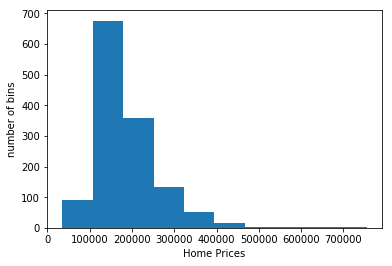

In [8]:
#Check distribution of sales price (target variable)

plt.figure(figsize=(6,4))

plt.hist(prices_df['saleprice'])
plt.xlabel('Home Prices')
plt.ylabel('number of bins')
plt.show()

In [9]:
#Look at correlations among feastures and target variable
numeric_columns = prices_df.select_dtypes(['int64', 'float64']).columns
non_numeric_columns = prices_df.select_dtypes(['object']).columns

np.abs(prices_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.783546
grlivarea        0.711706
garagecars       0.640154
garagearea       0.607535
firstflrsf       0.604714
totalbsmtsf      0.602042
fullbath         0.569313
totrmsabvgrd     0.551821
yearbuilt        0.504297
yearremodadd     0.501435
garageyrblt      0.481730
masvnrarea       0.465811
fireplaces       0.445434
bsmtfinsf1       0.359677
lotfrontage      0.327831
openporchsf      0.322786
secondflrsf      0.311354
wooddecksf       0.305983
halfbath         0.258175
lotarea          0.254757
bsmtfullbath     0.209695
bsmtunfsf        0.191689
bedroomabvgr     0.169266
enclosedporch    0.127385
kitchenabvgr     0.111408
overallcond      0.108627
screenporch      0.096624
poolarea         0.091881
threessnporch    0.042159
mosold           0.041310
bsmtfinsf2       0.031226
bsmthalfbath     0.030175
yrsold           0.020451
miscval          0.016990
lowqualfinsf     0.009992
Name: saleprice, dtype: float64

In [10]:
#First feature will be to create a total sq ft feature
prices_df['totalsqft'] = prices_df['firstflrsf'] + prices_df['totalbsmtsf']+ prices_df['secondflrsf'] + prices_df['bsmtfinsf1'] + prices_df['bsmtunfsf'] + prices_df['bsmtunfsf'] + prices_df['openporchsf'] + prices_df['bsmtfinsf2'] + prices_df['lowqualfinsf']

In [11]:
#Remove the outliers

import scipy.stats as stats
from scipy.stats.mstats import winsorize

def using_mstats(s):
    return winsorize(s, limits=[0.05, 0.05])

prices = prices_df.apply(using_mstats, axis=0)
prices.quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,...,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,totalsqft
0.00,20.0,36.000000,3230.00,4.0,5.0,1918.00,1950.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,2.0,2006.0,100000.0,2624.00
0.05,20.0,36.000000,3303.10,4.0,5.0,1918.85,1950.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,2.0,2006.0,100000.0,2626.55
0.25,20.0,60.000000,7744.00,5.0,5.0,1956.00,1968.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,5.0,2007.0,135000.0,3361.00
0.50,50.0,70.049958,9600.00,6.0,5.0,1976.00,1994.5,0.0,413.0,0.00,...,28.0,0.00,0.0,0.0,0.0,0.0,6.0,2008.0,168500.0,4132.50
0.75,70.0,80.000000,11760.75,7.0,6.0,2001.00,2004.0,174.0,733.0,0.00,...,70.0,0.00,0.0,0.0,0.0,0.0,8.0,2009.0,220000.0,5113.25
0.95,160.0,105.000000,17508.85,8.0,8.0,2007.00,2007.0,464.3,1280.3,412.35,...,172.3,180.45,0.0,168.0,0.0,0.0,11.0,2010.0,335000.0,6728.95
1.00,160.0,105.000000,17542.00,8.0,8.0,2007.00,2007.0,466.0,1282.0,420.00,...,174.0,183.00,0.0,168.0,0.0,0.0,11.0,2010.0,335000.0,6740.00


### 3) Select features (variables) for the model and do some feature engineering   

In [12]:
#Create a dummy variables for mszoning
prices['mszoning'] = pd.get_dummies(prices.mszoning, drop_first=True)

### Selected Features for first model

Target Variable (y) = saleprice

Features: 
    x1 = overallqual
    x2 = grlivarea
    x3 = garagecars
    x4 = totalsqft
    x5 = mszoning
  

### 4) Build Linear Regression Model and split your data into train and test sets where 20% of the data resides in the test set.

In [13]:
import statsmodels.api as sm

#First model will use all features

# Y is the target variable
Y = prices['saleprice']
# X is the feature set which includes lot size, overallcond, full & half bath, bedroomabvgr and totalbsmtsf
numeric_columns = prices_df.select_dtypes(['int64', 'float64']).columns
X = prices[numeric_columns]


# We need to manually add a constant in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.489e+27
Date:                Fri, 06 Sep 2019   Prob (F-statistic):               0.00
Time:                        23:34:30   Log-Likelihood:                 23033.
No. Observations:                1338   AIC:                        -4.600e+04
Df Residuals:                    1304   BIC:                        -4.582e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
mssubclass     1.741e-13   7.53e-12      0.023      0.982   -1.46e-11     1.5e-11
lotfrontage    1.998e-12   1.79e-11      0.112      0.911   -3.31e-11    3.71e-11
lotarea        8.334e-15   9.24e-14      0.090      0.928   -1.73e-13     1.9e-13
overallqual    3.059e-11   3.55e-10      0.086      0.931   -6.66e-10    7.27e-10
overallcond    1.663e-11   3.33e-10      0.050      0.960   -6.37e-10    6.71e-10
yearbuilt       5.32e-13   2.14e-11      0.025      0.980   -4.15e-11    4.26e-11
yearremodadd  -6.972e-13   1.85e-11     -0.038      0.970   -3.69e-11    3.55e-11
masvnrarea    -1.127e-14   1.84e-12     -0.006      0.995   -3.61e-12    3.59e-12
bsmtfinsf1     1.168e-13   2.33e-12      0.050      0.960   -4.45e-12    4.68e-12
bsmtfinsf2    -1.554e-14   3.92e-12     -0.004      0.997   -7.71e-12    7.68e-12
bsmtunfsf      4.174e-14   2.79e-12      0.015      0.988   -5.43e-12    5.51e-12
totalbsmtsf   -1.279e-13   4.65e-12     -0.028      0.978   -9.25e-12    8.99e-12
firstflrsf     -1.08e-13   3.07e-12     -0.035      0.972   -6.14e-12    5.92e-12
secondflrsf   -1.087e-13   2.66e-12     -0.041      0.967   -5.34e-12    5.12e-12
lowqualfinsf   1.626e-19   1.39e-17      0.012      0.991   -2.72e-17    2.75e-17
grlivarea      8.238e-14   3.17e-12      0.026      0.979   -6.14e-12    6.31e-12
bsmtfullbath    1.66e-11   6.68e-10      0.025      0.980   -1.29e-09    1.33e-09
bsmthalfbath   2.132e-11   1.02e-09      0.021      0.983   -1.99e-09    2.03e-09
fullbath       3.087e-11   7.63e-10      0.040      0.968   -1.47e-09    1.53e-09
halfbath       3.752e-12   6.89e-10      0.005      0.996   -1.35e-09    1.35e-09
bedroomabvgr  -1.327e-11   5.25e-10     -0.025      0.980   -1.04e-09    1.02e-09
kitchenabvgr  -9.633e-09   3.48e-07     -0.028      0.978   -6.93e-07    6.74e-07
totrmsabvgrd   1.366e-11   3.09e-10      0.044      0.965   -5.93e-10     6.2e-10
fireplaces    -4.434e-12   4.44e-10     -0.010      0.992   -8.75e-10    8.66e-10
garageyrblt    1.528e-13   2.13e-11      0.007      0.994   -4.16e-11    4.19e-11
garagecars     1.738e-11   7.75e-10      0.022      0.982    -1.5e-09    1.54e-09
garagearea    -1.537e-13   2.82e-12     -0.054      0.957   -5.69e-12    5.38e-12
wooddecksf     -9.77e-14   2.24e-12     -0.044      0.965   -4.49e-12    4.29e-12
openporchsf    5.329e-15   5.09e-12      0.001      0.999   -9.97e-12    9.98e-12
enclosedporch  1.807e-13   5.08e-12      0.036      0.972   -9.78e-12    1.01e-11
threessnporch   3.36e-22   2.44e-21      0.138      0.891   -4.45e-21    5.13e-21
screenporch    2.238e-13   5.47e-12      0.041      0.967   -1.05e-11     1.1e-11
poolarea        4.33e-23   7.73e-23      0.560      0.576   -1.08e-22    1.95e-22
miscval                0          0        nan        nan           0           0
mosold        -2.544e-12   8.98e-11     -0.028   

In [14]:
import statsmodels.api as sm

#Second model will use selected features

# Y is the target variable
Y = prices['saleprice']

# X is the feature set which includes overallqual, grlivarea, garagecars, totalsqft & mszoning
X = prices[['overallqual','grlivarea', 'garagecars', 'totalsqft', 'mszoning']]


# We need to manually add a constant in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     949.7
Date:                Fri, 06 Sep 2019   Prob (F-statistic):               0.00
Time:                        23:34:30   Log-Likelihood:                -15693.
No. Observations:                1338   AIC:                         3.140e+04
Df Residuals:                    1332   BIC:                         3.143e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.965e+04   4407.193    -20.341      0.000   -9.83e+04    -8.1e+04
overallqual  2.166e+04    970.660     22.319      0.000    1.98e+04    2.36e+04
grlivarea      38.6421      2.665     14.500      0.000      33.414      43.870
garagecars   2.058e+04   1735.495     11.856      0.000    1.72e+04     2.4e+04
totalsqft       9.8151      1.076      9.125      0.000       7.705      11.925
mszoning     -1.32e+04   9130.207     -1.446      0.148   -3.11e+04    4708.014
==============================================================================
Omnibus:                       43.730   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.060
Skew:                          -0.186   Prob(JB):                     1.68e-20
Kurtosis:                       4.223   Cond. No.                     5.26e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The second model is much better; in the first model the Adjusted R Square was equal to 1 which indicates a very unreliable model.  In this model, the adjusted R square equals .78.  Given that the 'mszoning' coefficient is statistically insignifcant we should drop that feature from the model to improve predictability.  

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

In [16]:
#Split the data into training and test data

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1070
The number of observations in test set is 268


In [17]:
#Estimate the model using only training data set

# Y is the target variable
# Y = prices['saleprice']

# X is the feature set which includes lot size, overallcond, full & half bath, bedroomabvgr and totalbsmtsf
X = prices[['overallqual','grlivarea', 'garagecars', 'totalsqft', 'mszoning']]

# We need to manually add a constant in statsmodels' sm
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     803.3
Date:                Fri, 06 Sep 2019   Prob (F-statistic):               0.00
Time:                        23:34:31   Log-Likelihood:                -12534.
No. Observations:                1070   AIC:                         2.508e+04
Df Residuals:                    1064   BIC:                         2.511e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.417e+04   4888.879    -19.262      0.000   -1.04e+05   -8.46e+04
overallqual  2.273e+04   1084.672     20.954      0.000    2.06e+04    2.49e+04
grlivarea      38.9492      2.896     13.449      0.000      33.266      44.632
garagecars   1.932e+04   1911.352     10.109      0.000    1.56e+04    2.31e+04
totalsqft       9.8320      1.174      8.375      0.000       7.528      12.135
mszoning    -9521.6757   1.06e+04     -0.902      0.368   -3.02e+04    1.12e+04
==============================================================================
Omnibus:                       16.342   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.314
Skew:                          -0.134   Prob(JB):                     5.25e-06
Kurtosis:                       3.688   Cond. No.                     5.54e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

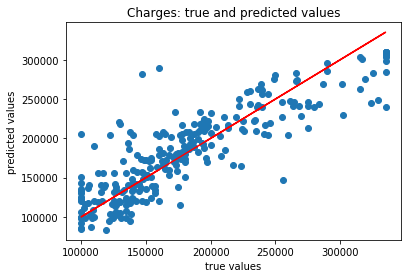

In [18]:
# Don't forget to add the constant to the model. Run the model on the test set now
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

Using the training data we get a slight improvemet in Adjusted R square howver the mszoning feature conitnues to deteriorate the performacne of the model.  Applying test data we see that the model works best when sales prices are lower and as sales prices increase the model's predictability worsens. 

In [19]:
#Use cross validation versus holdouts to see if performance on trainig set inproves
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score

bnb = BernoulliNB()
cross_val_score(bnb, X, Y, cv=5)

array([0.02348993, 0.04210526, 0.07      , 0.0952381 , 0.11818182])

In [20]:
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("Mean absolute error of the training set is: {}".format(mean_absolute_error(y_train, y_preds_train)))
print("Mean squared error of the training set is: {}".format(mse(y_train, y_preds_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.7905673797713356
Mean absolute error of the training set is: 23196.297733379324
Mean squared error of the training set is: 875015029.3382411
-----Test set statistics-----
R-squared of the model in the test set is: 0.736976355603061
Mean absolute error of the prediction is: 23366.286719654738
Mean squared error of the prediction is: 1011840915.1591321
Root mean squared error of the prediction is: 31809.446948338038
Mean absolute percentage error of the prediction is: 14.027748195119488


In [21]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**4) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("Mean absolute error of the training set is: {}".format(mean_absolute_error(y_train, y_preds_train)))
print("Mean squared error of the training set is: {}".format(mse(y_train, y_preds_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.6566211774965587
Mean absolute error of the training set is: 28075.7458762556
Mean squared error of the training set is: 1434645806.9374626
-----Test set statistics-----
R-squared of the model on the test set is: 0.6238945911831608
Mean absolute error of the prediction is: 28319.337816101055
Mean squared error of the prediction is: 1446861714.3758147
Root mean squared error of the prediction is: 38037.63549927643
Mean absolute percentage error of the prediction is: 16.967971925655938


In [22]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**3.5) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("Mean absolute error of the training set is: {}".format(mean_absolute_error(y_train, y_preds_train)))
print("Mean squared error of the training set is: {}".format(mse(y_train, y_preds_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7807231774803199
Mean absolute error of the training set is: 23394.134049646236
Mean squared error of the training set is: 916144367.0081794
-----Test set statistics-----
R-squared of the model on the test set is: 0.7246700180544163
Mean absolute error of the prediction is: 23848.416938411618
Mean squared error of the prediction is: 1059182878.9435202
Root mean squared error of the prediction is: 32545.08993601831
Mean absolute percentage error of the prediction is: 14.332820780752705


In [23]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=10**5, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("Mean absolute error of the training set is: {}".format(mean_absolute_error(y_train, y_preds_train)))
print("Mean squared error of the training set is: {}".format(mse(y_train, y_preds_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.6237899793445497
Mean absolute error of the training set is: 29797.954562352
Mean squared error of the training set is: 1571815421.5983686
-----Test set statistics-----
R-squared of the model on the test set is: 0.5932364928122251
Mean absolute error of the prediction is: 29865.316972726177
Mean squared error of the prediction is: 1564802131.4201133
Root mean squared error of the prediction is: 39557.57994898214
Mean absolute percentage error of the prediction is: 17.842040460697913


There's not a lot of difference in the errors between the test and training data set. The 

### 6) Find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [24]:
#Create a dictionary for 30 yr rates
dict1 = {2006: .0641,
         2007: .0634,
         2008: .0603,
         2009: .0504, 
         2010: .0469}


#Create dataframe for mortgage rates for the 5 years
rates_df= pd.DataFrame([[2006, .0641],
                       [2007, .0634],
                       [2008, .0603],
                       [2009, .0504], 
                       [2010, .0469]], 
                       columns=['yrsold', '30yrrate'])

rates_df.head()

,yrsold,30yrrate
0,2006,0.0641
1,2007,0.0634
2,2008,0.0603
3,2009,0.0504
4,2010,0.0469


In [25]:
#Create a dictionary for unemployment
dict2 = {2006: .0470,
         2007: .0460,
         2008: .0500,
         2009: .0780, 
         2010: .0980}


#Create dataframe for mortgage rates for the 5 years
unemp_df= pd.DataFrame([[2006, .0470],
                       [2007, .0460],
                       [2008, .0500],
                       [2009, .0780], 
                       [2010, .0980]], 
                       columns=['yrsold', 'unemp'])

unemp_df.head()

,yrsold,unemp
0,2006,0.047
1,2007,0.046
2,2008,0.050
3,2009,0.078
4,2010,0.098


In [26]:
#Merge with existing dataframe
prices=prices.merge(rates_df, on='yrsold')
prices=prices.merge(unemp_df, on='yrsold')

In [27]:
prices.head()

,mssubclass,mszoning,lotfrontage,lotarea,lotshape,lotconfig,neighborhood,condition1,housestyle,overallqual,...,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,totalsqft,30yrrate,unemp
0,60,0,65.0,8450,Reg,Inside,CollgCr,Norm,2Story,7,...,0,0,2,2008,WD,Normal,208500,3633,0.0603,0.05
1,60,0,68.0,11250,IR1,Inside,CollgCr,Norm,2Story,7,...,0,0,9,2008,WD,Normal,223500,4102,0.0603,0.05
2,60,0,84.0,14260,IR1,FR2,NoRidge,Norm,2Story,8,...,0,0,11,2008,WD,Normal,250000,5062,0.0603,0.05
3,50,0,51.0,6120,Reg,Inside,OldTown,Feedr,1.5Fin,7,...,0,0,4,2008,WD,Abnorml,129900,4630,0.0603,0.05
4,160,0,50.0,7420,Reg,Corner,BrkSide,Feedr,1.5Unf,5,...,0,0,2,2008,WD,Normal,118000,3203,0.0603,0.05


In [28]:
#Third model will use selected features + 30yrrates

# Y is the target variable
Y = prices['saleprice']

# X is the feature set which includes overallqual, grlivarea, garagecars, totalsqft & mszoning
X = prices[['overallqual','grlivarea', 'garagecars', 'totalsqft', '30yrrate']]


# We need to manually add a constant in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     947.9
Date:                Fri, 06 Sep 2019   Prob (F-statistic):               0.00
Time:                        23:34:31   Log-Likelihood:                -15694.
No. Observations:                1338   AIC:                         3.140e+04
Df Residuals:                    1332   BIC:                         3.143e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.699e+04   8371.282    -10.392      0.000   -1.03e+05   -7.06e+04
overallqual  2.168e+04    971.305     22.319      0.000    1.98e+04    2.36e+04
grlivarea      38.6498      2.667     14.491      0.000      33.417      43.882
garagecars   2.066e+04   1736.578     11.895      0.000    1.73e+04    2.41e+04
totalsqft       9.8475      1.076      9.151      0.000       7.736      11.959
30yrrate     -5.45e+04   1.24e+05     -0.438      0.661   -2.98e+05    1.89e+05
==============================================================================
Omnibus:                       43.846   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.701
Skew:                          -0.190   Prob(JB):                     2.02e-20
Kurtosis:                       4.218   Cond. No.                     7.17e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
#Forth model will use selected features + unemp

# Y is the target variable
Y = prices['saleprice']

# X is the feature set which includes overallqual, grlivarea, garagecars, totalsqft & mszoning
X = prices[['overallqual','grlivarea', 'garagecars', 'totalsqft', 'unemp']]


# We need to manually add a constant in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     947.9
Date:                Fri, 06 Sep 2019   Prob (F-statistic):               0.00
Time:                        23:34:31   Log-Likelihood:                -15694.
No. Observations:                1338   AIC:                         3.140e+04
Df Residuals:                    1332   BIC:                         3.143e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -9.11e+04   5192.702    -17.543      0.000   -1.01e+05   -8.09e+04
overallqual  2.168e+04    971.304     22.322      0.000    1.98e+04    2.36e+04
grlivarea      38.6465      2.667     14.489      0.000      33.414      43.879
garagecars   2.065e+04   1736.600     11.893      0.000    1.72e+04    2.41e+04
totalsqft       9.8457      1.076      9.149      0.000       7.735      11.957
unemp        1.572e+04   4.41e+04      0.356      0.722   -7.08e+04    1.02e+05
==============================================================================
Omnibus:                       43.848   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.742
Skew:                          -0.190   Prob(JB):                     1.98e-20
Kurtosis:                       4.218   Cond. No.                     2.54e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
#Split the data into training and test data

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1070
The number of observations in test set is 268


In [35]:
#Estimate the model using only training data set

# Y is the target variable
# Y = prices['saleprice']

# X is the feature set which includes lot size, overallcond, full & half bath, bedroomabvgr and totalbsmtsf
X = prices[['overallqual','grlivarea', 'garagecars', 'totalsqft']]

# We need to manually add a constant in statsmodels' sm
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     761.4
Date:                Fri, 06 Sep 2019   Prob (F-statistic):               0.00
Time:                        23:35:07   Log-Likelihood:                -12548.
No. Observations:                1070   AIC:                         2.511e+04
Df Residuals:                    1064   BIC:                         2.514e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.605e+04   5798.857    -14.839      0.000   -9.74e+04   -7.47e+04
overallqual  2.144e+04   1109.449     19.325      0.000    1.93e+04    2.36e+04
grlivarea      38.3552      3.001     12.782      0.000      32.467      44.243
garagecars   2.111e+04   1927.489     10.955      0.000    1.73e+04    2.49e+04
totalsqft       9.6096      1.207      7.964      0.000       7.242      11.977
unemp       -2.929e+04   4.85e+04     -0.603      0.546   -1.25e+05    6.59e+04
==============================================================================
Omnibus:                       40.736   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.265
Skew:                          -0.168   Prob(JB):                     1.25e-21
Kurtosis:                       4.431   Cond. No.                     2.49e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.49e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
#Use cross validation versus holdouts to see if performance on trainig set inproves

bnb = BernoulliNB()
cross_val_score(bnb, X, Y, cv=5)

array([0.02348993, 0.04912281, 0.07      , 0.0952381 , 0.11818182])

In [33]:
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)


print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.7815532548958111
-----Test set statistics-----
R-squared of the model in the test set is: 0.7756412272227687
Mean absolute error of the prediction is: 23702.835986427595
Mean squared error of the prediction is: 922488789.521788
Root mean squared error of the prediction is: 30372.50054772883
Mean absolute percentage error of the prediction is: 14.064439947145443


In [34]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**2) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)



print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7790439922969473
-----Test set statistics-----
R-squared of the model on the test set is: 0.7750870797343752
Mean absolute error of the prediction is: 23686.284106338368
Mean squared error of the prediction is: 924767260.0244426
Root mean squared error of the prediction is: 30409.986189152445
Mean absolute percentage error of the prediction is: 14.003583236464415


I attempted to add 30ye fixed mortage rates and unemployment as additional features to the pricing model however these features has little affect on the overall performance of the model.  Using cross-validation, the model's performance was very sporadic which indicates there is a lot of overfitting in the model given the existing features.  The model should be tested for linearity and also the various features should be adjusted.  Perhaps consider introducing PCA for some of the more highly correlated features to improve the models performance.    